# **The Effect of Reflected Inertia on Gain Tuning**

In [1]:
# python libraries
import mpld3
import numpy as np
from matplotlib import pyplot as plt
from pydrake.all import (
    ConstantVectorSource,
    DiagramBuilder,
    PidController,
    Simulator,
    SymbolicVectorSystem,
    Variable,
    VectorLogSink,
    sin,
)

from manipulation import running_as_notebook
from manipulation.exercises.grader import Grader
from manipulation.exercises.robot.test_reflected_inertia import (
    TestSimplePendulumWithGearbox,
)
from manipulation.utils import RenderDiagram

# enable mpld3 notebook
if running_as_notebook:
    mpld3.enable_notebook()

## Problem Description
You will notice that in the first few weeks of the lecture, we don't think a lot about the full second-order dynamics of the arm (a more complicated version of $F=ma$), although we will come to revisit this later. This problem set helps to understand one of the reasons why we can abstract many manipulation problems kinematically (purely in terms of joint angles and end-effector positions), as opposed to worrying about dynamics (joint torques and inertias). Even before going to the multi-link case, let's think about how we should control the position of a single pendulum.

In this problem you will investigate the role of reflected inertia in position control of a simple pendulum. At the end of the notebook, you will be able to check your work in a simulation environment.

**These are the main steps of the exercise:**
1. Write down the state-space dynamics function for the simple pendulum with motor and gearbox.
2. Set up a PID Controller to do position control for the simple pendulum.
3. Qualitatively answer the difference in behavior between direct-drive and gearbox cases.


**Your job for this problem set**
Will be to do step 1 and 3 of the main steps.



## The Simple Pendulum

<img src="https://raw.githubusercontent.com/RussTedrake/manipulation/master/book/figures/exercises/simple_pendulum.png" width="400">

The [simple pendulum](https://underactuated.csail.mit.edu/pend.html) is perhaps the simplest abstraction of a 'manipulator', with the following equation for dynamics:

$$ ml^2 \ddot{q} = -mgl\sin(q) + \tau$$

Let's first write down the dynamics of a pendulum in a first-order form,
$$\dot{x}=f(x,u)$$

where $x=[q,\dot{q}]^T$ is now our state vector, and our input $u=\tau$.

$$\frac{d}{dt}\begin{bmatrix} q \\ \dot{q} \end{bmatrix}=\begin{bmatrix} \dot{q} \\ (-mgl\sin(q) + \tau) / ml^2 \end{bmatrix}$$

The following function returns $\dot{x}$ given $x,u$, and the parameters.

NOTE: For a sine implementation, we will be using `pydrake`'s `sin` for this problem set instead of the numpy implementation. We've already imported it above, so it is available by simply calling `sin()`. This version will not only support numeric, but also symbolic computation.

In [4]:
def pendulum_dynamics(x, u, p):
    q = x[0]
    qdot = x[1]
    tau = u[0]
    return [
        qdot,
        ((-p["m"] * p["g"] * p["l"] * sin(q) + tau) / (p["m"] * p["l"] ** 2)),
    ]

## System Dynamics

From a systems viewpoint, how should this dynamics be abstracted into a system that we can define inputs and outputs on?

As explained in the lecture notes, we can abstract the dynamics as a "plant" that will tell us what the current state $x$ is, given the torque  $\tau$ into the system. If we were to draw a system diagram of this plant, it would look like:

<img src="https://raw.githubusercontent.com/RussTedrake/manipulation/master/book/figures/exercises/simple_pendulum_diagram.png" width="500">


To implement this system in [drake](https://drake.mit.edu), we will be using a [`SymbolicVectorSystem`](https://drake.mit.edu/pydrake/pydrake.systems.primitives.html#pydrake.systems.primitives.SymbolicVectorSystem). This is one of the convenient ways to define a system if you have access to a relatively simple, symbolic form of your dynamics. But these equations will get complicated as we move to the multi-link case!

Note that the output of the system doesn't have to be the state $x$ - it can be a subset of the state, or simply some sensor attached to the pendulum! In this case we will assume full access to the state for feedback (i.e. doing full-state feedback), so we simply set `output=x` as well.

In [10]:
context = system.CreateDefaultContext()
print(context)

::_ Context
------------
Time: 0
States:
  2 continuous states
    0 0




## The Simple Pendulum with Motor and Gearbox

In class, we saw that the presence of a physical motor and a gearbox can affect the dynamics significantly.

**Now it's your turn to code!**

Below, you will implement a similar dynamics function for a simple pendulum, which now has a physical motor and a gearbox attached to it.

<img src="https://raw.githubusercontent.com/RussTedrake/manipulation/master/book/figures/exercises/pendulum_with_motor.png" width="700">

In addition to the given parameters of mass (`p["m"]`), gravity (`p["g"]`), and length (`p["l"]`), you will need rotor inertia of the motor $I_m$, as well as the gear ratio, $N$. You can assume these can be accessed by `p["I_m"]` and `p["N"]`.

NOTE: For this model, we want the state, $x = [q, \dot{q}],$ to be the joint angles (not $q_{motor}$), but we want the input, $u = \tau_{motor},$ to be the _motor_ torque.

NOTE: Again, do not use `np.sin`!

HINT: Are the dynamics what you expect when `N=1` (i.e. direct-drive)?

In [19]:
# Modify this function. you may not change the function name, inputs, or size of the output.


def pendulum_with_motor_dynamics(x, u, p):
    x[0]
    x[1]
    u[0]
    k= p["I_m"]+p["m"]*p["l"]**2/p["N"]**2 # I_motor+I_pendilum/N**2
    x_dot=x[1]

    x_double_dot = ( (-p["m"]*p["g"]*p["l"]* sin(x[0]))/p["N"]**2 + u[0]/p["N"] )*(k**(-1)) 
    
    return [x_dot, x_double_dot]  # modify here  # modify here # it is the dynamics of the system

You can check if you got the dynamics correct by running the below autograder.

In [22]:
Grader.grade_output([TestSimplePendulumWithGearbox], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 5/5.

Score for Test state space dynamics is 5/5.


## Parameter Setting

Now we have defined the dynamics, we can play around with the parameters. We will try to control a pendulum of endpoint mass `m=1kg`, at length `0.5m`. To make the case more fun, let's base the gear ratio `N` and motor inertia `I_m` from Kuka iiwa [(DLR LWR III)](https://www.dlr.de/rm/en/desktopdefault.aspx/tabid-12464/21732_read-49777 )'s 3rd joint.

The iiwa uses a [harmonic drive](https://en.wikipedia.org/wiki/Strain_wave_gearing) geared 160:1, directly from the [HD Company](https://www.harmonicdrive.net/) , and high-performance frameless motors [RoboDrive ILM](https://www.tq-group.com/en/products/tq-robodrive/) from TQ (originally developed at DLR). We will make an educated guess for what exact models they are using:

- RoboDrive ILM 85, with `I_m=0.61e-4 kg m^2`
- HD SHF-32-160-2UH-LW, with `I_m=2.85e-4 kg m^2`

The "motor inertia" in the problem is in fact the armature inertia of the motor, as well as the part of the transmission attached to the motor shaft!

In [25]:
# Add motor and gearbox parameters

p = {
    "N": 160,
    "I_m": 3.46e-4,
    "m": 1.0,  # kg
    "g": 9.81,  # m / s^2
    "l": 0.5,  # m
}

## Building a PID Controlled System

Now we have to do some plumbing to simulate the system in [Drake](https://drake.mit.edu). We've defined the plant for our dynamics before, but we need to hook it up to a PID controller to do position control, so we will need another system to act as a controller.

Drake offers a built-in [PID Controller](https://drake.mit.edu/pydrake/pydrake.systems.controllers.html#pydrake.systems.controllers.PidController). The role of the controller is to compute the error based on the current and desired states, and command the input, so it could be abstracted by a system with
- Input ports: x_now ($x$), x_desired ($x_d$)
- Output ports: torque command ($\tau_{cmd}$)

Are there any other systems that we need to consider? Let's think about the requirements of what we need to implement. Since we need to command $x_d$, we might want a `Slider` or a `ConstantVectorSource` to do so. Also, we would like to plot the trajectory of the system, so we might need a `Logger` to do this for us.

Before we code and hook everything up, it pays to think about what our diagram will actually look like:

<img src="https://raw.githubusercontent.com/RussTedrake/manipulation/master/book/figures/exercises/system_diagram.png" width="1000">



Did we get all the systems that we want? Are all the IO ports hooked up to the right places? Seems like we are ready to code!

In [34]:
def BuildAndSimulate(q_d, pendulum_params, gains, visualize=False):
    # This defines the plant using the pendulum with motor dynamics.
    system = SymbolicVectorSystem(
        state=x,
        output=x,
        input=u,
        dynamics=pendulum_with_motor_dynamics(x, u, pendulum_params),
    )

    kp, ki, kd = gains

    builder = DiagramBuilder()

    # Add all the systems into the diagram
    builder.AddSystem(system) # what is a system exactly here?
    logger = builder.AddSystem(VectorLogSink(2))
    pid_controller = builder.AddSystem(PidController([kp], [ki], [kd]))
    desired_state = builder.AddSystem(ConstantVectorSource([q_d, 0.0]))

    # Connect the IO ports of the systems.
    builder.Connect(pid_controller.get_output_port(0), system.get_input_port(0))
    builder.Connect(system.get_output_port(0), logger.get_input_port(0))
    builder.Connect(system.get_output_port(0), pid_controller.get_input_port(0))
    builder.Connect(desired_state.get_output_port(0), pid_controller.get_input_port(1))

    diagram = builder.Build()
    diagram.set_name("diagram")

    # Plot the diagram if visualize is true.
    if visualize and running_as_notebook:
        RenderDiagram(diagram, max_depth=1)

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # The simulator has three states since the plant has 2, and the PID controller
    # keeps an additional state for the integral term. We set all of them to zero - doubt what is the menaning of additional state for the integral term?
    # initialization.
    context.SetContinuousState([0.0, 0.0, 0.0])

    return simulator, logger.FindLog(context)

Now let's visualize the diagram and see if everything is properly connected for simulation. Does this topologically resemble our diagram above?

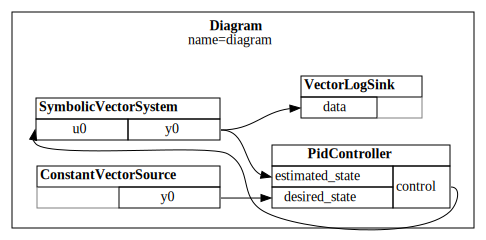

In [37]:
gains = [5, 2, 1]
simulator, logger = BuildAndSimulate(0.0, p, gains, visualize=True)

## Simulating the Closed-Loop System

We are now ready to simulate our system with motor dynamics! Let's start off with the direct-drive case (i.e. `N=1`).

In [40]:
q_d = (5.0 / 8.0) * np.pi  # Feel free to play around with different final positions.
gains = [5, 2, 1]  # [P, I, D] gains.
p["N"] = 1
simulator, logger = BuildAndSimulate(q_d, p, gains)

simulator.Initialize()
simulator.AdvanceTo(20.0 if running_as_notebook else 0.1)

time = logger.sample_times()
traj = logger.data()

plt.figure()
plt.plot(time, traj[0, :], "b-")
plt.plot(time, q_d * np.ones(traj.shape[1]), "r--")
plt.xlabel("time (s)")
plt.ylabel("q (rads)")
if running_as_notebook:
    display(mpld3.display())

You might have noticed that the closed-loop system is unstable for some desired joint configurations. For the gains above, if we ask the controller to stabilize to an upright position (do a swing-up), then the controller seems to be having trouble stabilizing.

Let's try to analyze this effect a bit more systematically by plotting how the state behaves depending on how we set the desired position.



In [43]:
plt.figure()
p["N"] = 1

q_d_lst = np.linspace(-np.pi, np.pi, 10)
for i in range(len(q_d_lst)):
    simulator, logger = BuildAndSimulate(q_d_lst[i], p, gains)

    simulator.Initialize()
    simulator.AdvanceTo(20.0 if running_as_notebook else 0.1)

    time = logger.sample_times()
    traj = logger.data()

    plt.plot(time, traj[0, :], "b--")
    plt.plot(time, q_d_lst[i] * np.ones(traj.shape[1]), "r--")

plt.xlabel("time (s)")
plt.ylabel("q (rads)")
if running_as_notebook:
    display(mpld3.display())

Note how that the system not only destabilizes for more upright positions, but also shows **different behavior** depending on what angle we ask it to stabilize to. Lower angles don't have overshoots, while higher angles do.

This speaks to the effect of the nonlinear, state-dependent gravity term
$-mgl\sin(q)$.


## Testing out Gearbox Case

Now we will test the same dynamics with a high gear ratio of `N=160`, with the same gains.

In [46]:
q_d = np.pi / 1  # Feel free to play around with different gains.
gains = [5, 2, 1]  # [P, I, D] gains
p["N"] = 160
simulator, logger = BuildAndSimulate(q_d, p, gains)

simulator.Initialize()
simulator.AdvanceTo(20.0 if running_as_notebook else 0.1)

time = logger.sample_times()
traj = logger.data()

plt.figure()
plt.plot(time, traj[0, :], "b-")
plt.plot(time, q_d * np.ones(traj.shape[1]), "r--")
plt.xlabel("time (s)")
plt.ylabel("q (rads)")
if running_as_notebook:
    display(mpld3.display())

Observe that with the same gains, the controller stabilizes is now able to stabilize to an upright position! Let's plot this over a range of different final joint positions as well.

In [49]:
plt.figure()
p["N"] = 160

q_d_lst = np.linspace(-np.pi, np.pi, 10)
for i in range(len(q_d_lst)):
    simulator, logger = BuildAndSimulate(q_d_lst[i], p, gains)

    simulator.Initialize()
    simulator.AdvanceTo(20.0 if running_as_notebook else 0.1)

    time = logger.sample_times()
    traj = logger.data()

    plt.plot(time, traj[0, :], "b--")
    plt.plot(time, q_d_lst[i] * np.ones(traj.shape[1]), "r--")

plt.xlabel("time (s)")
plt.ylabel("q (rads)")
if running_as_notebook:
    display(mpld3.display())

This is looking great! Now we are able to stabilize to most configurations. But not only did we achieve stability, but observe how **consistent** the curves are regardless of what joint configuration we ask it to stabilize to.

You will notice that with a higher gain, we might be able to achieve stability for the direct-drive case as well since we impose no torque bounds. But you are still likely to see that gravity affects the direct-drive case more than the gearbox case.




### Please answer the following questions on gradescope: 

## Gradescope Verification 1 

1. By looking at the simulation graph of the direct-drive case with $q_d = \frac{5}{8}\pi$, what is the approximate value of $q$ when $t = 4$ (to one decimal place)?

## Gradescope Verification 2

2. By looking at the simulation graph of the high gear ratio case with $q_d = \pi$, what is the approximate value of $q$ when $t = 4$ (to one decimal place)?

## Gradescope Verification 3

3. Why are we seeing such consistent behavior of closed-loop dynamics for the gearbox case, as opposed to the direct-drive case? Select all that apply. 

    A. The inertia of the pendulum is reduced by a factor of $\frac{1}{N}$ relative to the inertia of the motor.

    B. The inertia of the pendulum is reduced by a factor of $\frac{1}{N^2}$ relative to the inertia of the motor.

    C. The gravity torque is reduced by a factor of $\frac{1}{N}$ relative to the motor torque.

    D. The gravity torque is reduced by a factor of $\frac{1}{N^2}$ relative to the motor torque.

    E. For large $N$, the impact of changing load inertias and gravity loads are substantially reduced.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5d47f800-dc57-418e-ab91-0720ef24520e' target="_blank">

Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>